In [1]:
%load_ext autoreload
%autoreload 2

from pprint import pprint

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')


In [3]:
import collections

from rl.algs import environment
from rl.algs import experiment
from rl.algs import pg

TrainParams = collections.namedtuple(
  'TrainParams',
  'num_train_iters '
  'steps_per_batch '
  'steps_per_snapshot '
  'lr '
)


class Experiment(experiment.Experiment):
  def __init__(self, env_name, train_params, model_params):
    self.tp = train_params
    is_discrete = environment.Environment(env_name).discrete_ac
    model_cls = (pg.DiscreteActionModel if is_discrete
                 else pg.ContinuousActionModel)
    super().__init__(env_name, model_cls, model_params, pg.Policy,
                     {'lr': self.tp.lr})
  
  def train(self):
    for i in range(self.tp.num_train_iters):
      eps_batch = self.env.sample_rollouts(self.policy.get_action,
                                           self.tp.steps_per_batch)
      metrics = self.policy.update(eps_batch)

      if i % self.tp.steps_per_snapshot == 0:
        for name, m in metrics.items():
          self.plt.add_data(name, i, m)
        self.snapshots.add(i, self.policy)

    self.plt.line_plot()
    self.plt.render()


exps = {}

[2018-01-31 00:44:39,449] Making new env: CartPole-v1


[2018-01-31 00:44:39,452] Making new env: CartPole-v1


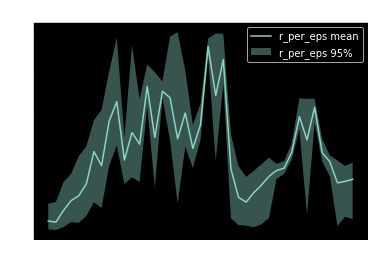

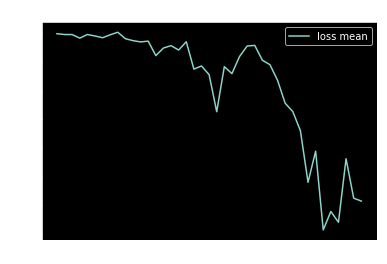

In [18]:
# Discrete task
env_name = 'CartPole-v1'
train_params = TrainParams(
  num_train_iters=201,
  steps_per_batch=1000,
  steps_per_snapshot=5,
  lr=0.005,
)
model_params = {
  'hidden_layers': (64,),
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [20]:
exps['CartPole-v1'].visualize(num_episodes=5)

Step: 105. Expected reward: 465.0


[2018-01-31 00:48:02,955] Making new env: CartPole-v1


Reward: mean 462.80, std 46.30 over 5 episodes.
Actual rewards: [[500.0, 500.0, 394.0, 500.0, 420.0]]


[2018-01-30 22:21:03,798] Making new env: CartPole-v0


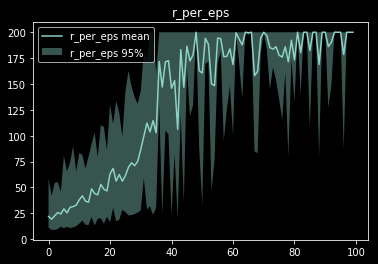

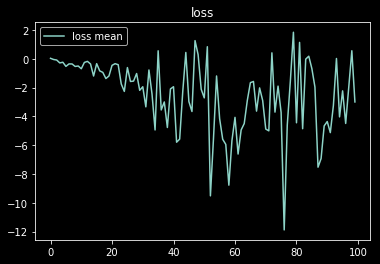

In [6]:
# Discrete task

from rl.algs import environment
from rl.algs import pg
from rl.algs import plotter

NUM_TRAIN_ITERS = 100
MAX_STEPS_PER_EPISODE = None  # default: None
STEPS_PER_BATCH = 1000
env = environment.Environment(max_episode_steps=MAX_STEPS_PER_EPISODE)
model = pg.DiscreteActionModel(env.obs_dim, env.acs_dim)
policy = pg.Policy(model, lr=0.005)

plt = plotter.Plotter()

for i in range(NUM_TRAIN_ITERS):
  eps_batch = env.sample_rollouts(policy.get_action, STEPS_PER_BATCH)
  m = policy.update(eps_batch)
  for name, metrics in m.items():
    plt.add_data(name, i, metrics)

plt.line_plot()
plt.render()


In [8]:
# Show an episode of the final policy
env.visualize(policy, num_episodes=3)


Reward: mean 200.00, std 0.00 over 3 episodes.


[200.0, 200.0, 200.0]

[2018-01-31 02:12:29,971] Making new env: RoboschoolInvertedPendulum-v1


[2018-01-31 02:12:29,972] Making new env: RoboschoolInvertedPendulum-v1


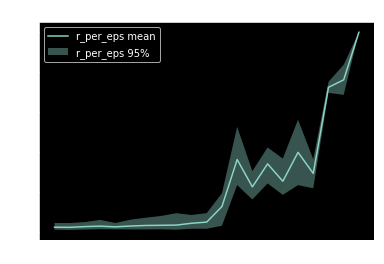

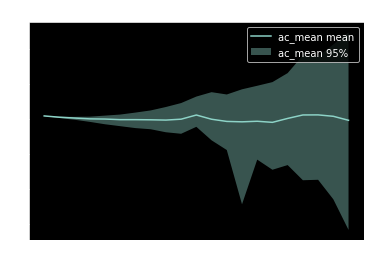

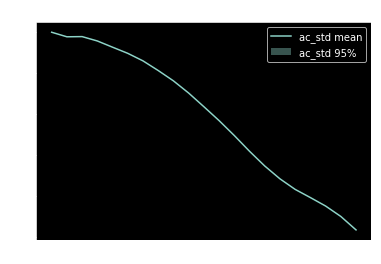

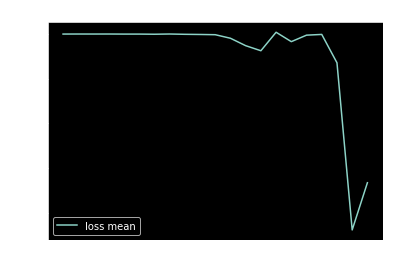

In [30]:
# Continuous task
import roboschool

env_name = 'RoboschoolInvertedPendulum-v1'
train_params = TrainParams(
  num_train_iters=101,
  steps_per_batch=1000,
  steps_per_snapshot=5,
  lr=0.001,
)
model_params = {
  'shared_layers': (64,) * 3,
  'action_layers': (64,) * 1,
  'model_std': False,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [32]:
exps['RoboschoolInvertedPendulum-v1'].visualize(num_episodes=3)


Step: 100. Expected reward: 1000.0


[2018-01-31 02:16:48,852] Making new env: RoboschoolInvertedPendulum-v1


Reward: mean 791.33, std 45.64 over 3 episodes.
Actual rewards: [[828.0, 727.0, 819.0]]


In [9]:
# Continuous task

import roboschool

from rl.algs import environment
from rl.algs import pg
from rl.algs import plotter

ENV_NAME = 'RoboschoolInvertedPendulum-v1'
#ENV_NAME = 'BipedalWalker-v2'
NUM_TRAIN_ITERS = 100
MAX_STEPS_PER_EPISODE = None  # default: None
STEPS_PER_BATCH = 5000
env = environment.Environment(
    env_name=ENV_NAME, max_episode_steps=MAX_STEPS_PER_EPISODE)
model = pg.ContinuousActionModel(
  env.obs_dim, env.acs_dim,
  #shared_layers=(64,) * 3,
  #action_layers=(64,) * 3,
  #model_std=True,
)
policy = pg.Policy(model, lr=0.001)
policy_snapshots = pg.PolicySnapshots()

plt = plotter.Plotter()

for i in range(NUM_TRAIN_ITERS):
  eps_batch = env.sample_rollouts(policy.get_action, STEPS_PER_BATCH)
  m = policy.update(eps_batch)
  for name, metrics in m.items():
    plt.add_data(name, i, metrics)
  
  if i % 5 == 0:
    policy_snapshots.snapshot(i, policy)

plt.line_plot()
plt.render()


[2018-01-30 01:30:52,950] Making new env: RoboschoolInvertedPendulum-v1


In [8]:
# Roboschool does not close properly on env.render(close=True)
# Workaround by creating new env and deleting it.
env = environment.Environment(
    ENV_NAME, max_episode_steps=MAX_STEPS_PER_EPISODE)
env.visualize(policy_snapshots.get(60))
del env

[2018-01-30 01:29:32,702] Making new env: RoboschoolInvertedPendulum-v1


Reward: mean 104.00, std 0.00 over 1 episodes.


In [9]:
# Scratchpad
import torch as th

mu = th.Tensor([0, 0.5, 1.0])
std = th.Tensor([1.0, 1.0, 1.0])

d = th.distributions.Normal(mu, std)
print(d)
a = th.Tensor([0, 0, 1.0])
th.exp(d.log_prob(a))

l = th.distributions.Normal(-0.2649, 1.1248).log_prob(-0.8086)
th.exp(th.Tensor([l]))



[4, 3, 2, 1]